0.2892265563101477
2.560377824284785
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 68s 136ms/step - loss: 0.2992 - val_loss: 0.2727
Epoch 2/20
500/500 [==============================] - 66s 132ms/step - loss: 0.2836 - val_loss: 0.2713
Epoch 3/20
500/500 [==============================] - 65s 131ms/step - loss: 0.2754 - val_loss: 0.2623
Epoch 4/20
500/500 [==============================] - 64s 128ms/step - loss: 0.2675 - val_loss: 0.2654
Epoch 5/20
500/500 [==============================] - 66s 131ms/step - loss: 0.2634 - val_loss: 0.2634
Epoch 6/20
500/500 [==============================] - 66s 131ms/step - loss: 0.2574 - val_loss: 0.2677
Epoch 7/20
500/500 [==============================] - 64s 128ms/step - loss: 0.2543 - val_loss: 0.2698
Epoch 8/20
500/500 [==============================] - 66s 133ms/step - loss: 0.2497 - val_loss: 0.2733
Epoch 9/20
500/500 [=========================

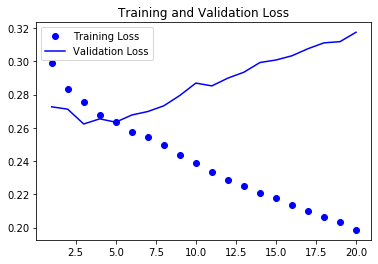

In [2]:
%%time
# Sequential Dense -> GRU
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

# jena 날씨 데이터셋 import
data_dir = '/Users/jaekunpark/Dataset/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

'''
print(header)
print(len(lines))
'''

# Data Parsing
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
'''   
# 시계열 온도 그래프
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.figure()
# 처음 10일간 온도 그래프
plt.plot(range(1440), temp[:1440])
'''

# Data Regularization
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

'''
data = Data Regularization에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
lookback = 1440 : 10일 전 데이터로 돌아간다 (입력으로 사용하기 위해 거슬러 올라갈 타임스텝)
delay = 144 : 24시간이 지난 데이터가 타겟이 된다. (타겟으로 사용할 미래의 타임스텝)
min_index, max_index : 추출할 타임스텝의 범위를 지정하기 위한 data배열의 인덱스. 검증,테스트 데이터를 분리하는데 사용
shuffle : 샘플을 섞을지, 시간 순서대로 추출할지를 결정
batch_size = 배치의 샘플 수
step = 6 : 데이터를 샘플링할 타임스텝 간격(1시간 마다 데이터 포인트 하나를 샘플링하기 위해 6으로 지정)
'''

# 시계열 데이터와 타깃을 반환하는 generator function
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        # samples = (128, 240, 14)
        targets = np.zeros((len(rows), ))
        # targets = (128, )
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
            
# 훈련, 검증, 테스트 제네레이터 준비
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000,
                     shuffle = True, step = step, batch_size = batch_size)
val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000,
                     shuffle = True, step = step, batch_size = batch_size)
test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 300001, max_index = None,
                     shuffle = True, step = step, batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
    # 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수 
    # generator()함수는 while문을 이용하여 무한 반복되므로 한 번 순회하는 횟수를 알려준다
test_steps = (len(float_data) - 300001 - lookback) // batch_size
    # 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
    
# 상식적인 기준 모델의 MAE(Mean Absolute Error) 계산
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        val_mae = np.mean(batch_maes)
        celsius_mae = val_mae * std[1]
    print(np.mean(batch_maes))
    print(celsius_mae)
    
evaluate_naive_method()

# 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기
'''
model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))
'''

model = Sequential()
model.add(layers.GRU(32, dropout = 0.2, recurrent_dropout = 0.2, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit(train_gen, steps_per_epoch = 500, epochs = 40, 
                              validation_data = val_gen, validation_steps = val_steps)

# 결과 그래프

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss ,'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

0.290337233634392
2.5702100942782837
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 103s 205ms/step - loss: 0.3329 - val_loss: 0.2765
Epoch 2/40
500/500 [==============================] - 97s 194ms/step - loss: 0.3126 - val_loss: 0.2723
Epoch 3/40
500/500 [==============================] - 97s 194ms/step - loss: 0.3064 - val_loss: 0.2679
Epoch 4/40
500/500 [==============================] - 97s 194ms/step - loss: 0.3004 - val_loss: 0.2654
Epoch 5/40
500/500 [==============================] - 99s 198ms/step - loss: 0.2988 - val_loss: 0.2674
Epoch 6/40
500/500 [==============================] - 97s 195ms/step - loss: 0.2973 - val_loss: 0.2660
Epoch 7/40
500/500 [==============================] - 101s 203ms/step - loss: 0.2940 - val_loss: 0.2678
Epoch 8/40
500/500 [==============================] - 100s 201ms/step - loss: 0.2921 - val_loss: 0.2631
Epoch 9/40
500/500 [======================

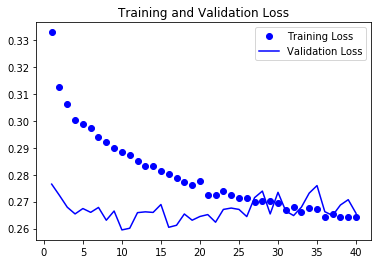

CPU times: user 2h 46min 44s, sys: 47min 31s, total: 3h 34min 16s
Wall time: 1h 5min 36s


In [3]:
%%time
# GRU + Dropout
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

# jena 날씨 데이터셋 import
data_dir = '/Users/jaekunpark/Dataset/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

'''
print(header)
print(len(lines))
'''

# Data Parsing
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
'''   
# 시계열 온도 그래프
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.figure()
# 처음 10일간 온도 그래프
plt.plot(range(1440), temp[:1440])
'''

# Data Regularization
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

'''
data = Data Regularization에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
lookback = 1440 : 10일 전 데이터로 돌아간다 (입력으로 사용하기 위해 거슬러 올라갈 타임스텝)
delay = 144 : 24시간이 지난 데이터가 타겟이 된다. (타겟으로 사용할 미래의 타임스텝)
min_index, max_index : 추출할 타임스텝의 범위를 지정하기 위한 data배열의 인덱스. 검증,테스트 데이터를 분리하는데 사용
shuffle : 샘플을 섞을지, 시간 순서대로 추출할지를 결정
batch_size = 배치의 샘플 수
step = 6 : 데이터를 샘플링할 타임스텝 간격(1시간 마다 데이터 포인트 하나를 샘플링하기 위해 6으로 지정)
'''

# 시계열 데이터와 타깃을 반환하는 generator function
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        # samples = (128, 240, 14)
        targets = np.zeros((len(rows), ))
        # targets = (128, )
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
            
# 훈련, 검증, 테스트 제네레이터 준비
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000,
                     shuffle = True, step = step, batch_size = batch_size)
val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000,
                     shuffle = True, step = step, batch_size = batch_size)
test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 300001, max_index = None,
                     shuffle = True, step = step, batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
    # 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수 
    # generator()함수는 while문을 이용하여 무한 반복되므로 한 번 순회하는 횟수를 알려준다
test_steps = (len(float_data) - 300001 - lookback) // batch_size
    # 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
    
# 상식적인 기준 모델의 MAE(Mean Absolute Error) 계산
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        val_mae = np.mean(batch_maes)
        celsius_mae = val_mae * std[1]
    print(np.mean(batch_maes))
    print(celsius_mae)
    
evaluate_naive_method()

# 드롭아웃 규제된 GRU를 사용한 모델을 훈련하고 평가하기
'''
model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))
'''

model = Sequential()
model.add(layers.GRU(32, dropout = 0.2, recurrent_dropout = 0.2, input_shape = (None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit(train_gen, steps_per_epoch = 500, epochs = 40, 
                              validation_data = val_gen, validation_steps = val_steps)

# 결과 그래프

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss ,'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

0.2889967340919921
2.5583433233094928
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 217s 433ms/step - loss: 0.3398 - val_loss: 0.2850
Epoch 2/40
500/500 [==============================] - 1165s 2s/step - loss: 0.3171 - val_loss: 0.2790
Epoch 3/40
500/500 [==============================] - 199s 398ms/step - loss: 0.3073 - val_loss: 0.2680
Epoch 4/40
500/500 [==============================] - 200s 399ms/step - loss: 0.3025 - val_loss: 0.2690
Epoch 5/40
500/500 [==============================] - 199s 398ms/step - loss: 0.2996 - val_loss: 0.2726
Epoch 6/40
500/500 [==============================] - 199s 397ms/step - loss: 0.2958 - val_loss: 0.2682
Epoch 7/40
500/500 [==============================] - 198s 397ms/step - loss: 0.2914 - val_loss: 0.2771
Epoch 8/40
500/500 [==============================] - 198s 397ms/s

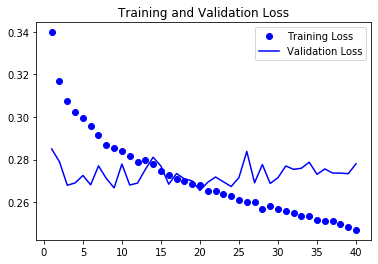

CPU times: user 6h 19min 45s, sys: 1h 45min 9s, total: 8h 4min 55s
Wall time: 2h 28min 35s


In [9]:
%%time

# GRU + Dropout + stacking recurrent layer

import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop



# jena 날씨 데이터셋 import
data_dir = '/Users/jaekunpark/Dataset/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

'''
print(header)
print(len(lines))
'''

# Data Parsing
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
'''   
# 시계열 온도 그래프
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.figure()
# 처음 10일간 온도 그래프
plt.plot(range(1440), temp[:1440])
'''

# Data Regularization
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

'''
data = Data Regularization에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
lookback = 1440 : 10일 전 데이터로 돌아간다 (입력으로 사용하기 위해 거슬러 올라갈 타임스텝)
delay = 144 : 24시간이 지난 데이터가 타겟이 된다. (타겟으로 사용할 미래의 타임스텝)
min_index, max_index : 추출할 타임스텝의 범위를 지정하기 위한 data배열의 인덱스. 검증,테스트 데이터를 분리하는데 사용
shuffle : 샘플을 섞을지, 시간 순서대로 추출할지를 결정
batch_size = 배치의 샘플 수
step = 6 : 데이터를 샘플링할 타임스텝 간격(1시간 마다 데이터 포인트 하나를 샘플링하기 위해 6으로 지정)
'''

# 시계열 데이터와 타깃을 반환하는 generator function
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        # samples = (128, 240, 14)
        targets = np.zeros((len(rows), ))
        # targets = (128, )
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
            
# 훈련, 검증, 테스트 제네레이터 준비
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000,
                     shuffle = True, step = step, batch_size = batch_size)
val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000,
                     shuffle = True, step = step, batch_size = batch_size)
test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 300001, max_index = None,
                     shuffle = True, step = step, batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
    # 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수 
    # generator()함수는 while문을 이용하여 무한 반복되므로 한 번 순회하는 횟수를 알려준다
test_steps = (len(float_data) - 300001 - lookback) // batch_size
    # 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
    
# 상식적인 기준 모델의 MAE(Mean Absolute Error) 계산
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        val_mae = np.mean(batch_maes)
        celsius_mae = val_mae * std[1]
    print(np.mean(batch_maes))
    print(celsius_mae)
    
evaluate_naive_method()

# 드롭아웃 규제된 GRU를 사용한 모델을 훈련 & 평가
'''
model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))
'''

model = Sequential()
model.add(layers.GRU(32,
                     dropout = 0.2,
                     recurrent_dropout = 0.2,
                     return_sequences = True,
                     input_shape = (None, float_data.shape[-1])))
model.add(layers.GRU(64,
                     activation = 'relu',
                     dropout = 0.1,
                     recurrent_dropout = 0.5))
model.add(layers.Dense(1))
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 40, 
                              validation_data = val_gen, validation_steps = val_steps)
tf.keras.backend.clear_session()

# 결과 그래프

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss ,'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

0.2911267841580556
2.5771995895643696
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 86s 172ms/step - loss: 0.2901 - val_loss: 0.2689
Epoch 2/40
500/500 [==============================] - 84s 169ms/step - loss: 0.2742 - val_loss: 0.2666
Epoch 3/40
500/500 [==============================] - 84s 168ms/step - loss: 0.2681 - val_loss: 0.2600
Epoch 4/40
500/500 [==============================] - 84s 168ms/step - loss: 0.2614 - val_loss: 0.2769
Epoch 5/40
500/500 [==============================] - 87s 173ms/step - loss: 0.2576 - val_loss: 0.2665
Epoch 6/40
500/500 [==============================] - 84s 168ms/step - loss: 0.2502 - val_loss: 0.2702
Epoch 7/40
500/500 [==============================] - 88s 175ms/step - loss: 0.2456 - val_loss: 0.2731
Epoch 8/40
500/500 [==============================] - 86s 171ms/step - 

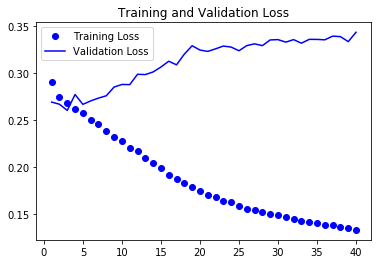

CPU times: user 4h 5min 37s, sys: 1h 12min 15s, total: 5h 17min 53s
Wall time: 56min 27s


In [2]:
%%time

# GRU + Dropout + stacking recurrent layer

import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop



# jena 날씨 데이터셋 import
data_dir = '/Users/jaekunpark/Dataset/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

'''
print(header)
print(len(lines))
'''

# Data Parsing
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
'''   
# 시계열 온도 그래프
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.figure()
# 처음 10일간 온도 그래프
plt.plot(range(1440), temp[:1440])
'''

# Data Regularization
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

'''
data = Data Regularization에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
lookback = 1440 : 10일 전 데이터로 돌아간다 (입력으로 사용하기 위해 거슬러 올라갈 타임스텝)
delay = 144 : 24시간이 지난 데이터가 타겟이 된다. (타겟으로 사용할 미래의 타임스텝)
min_index, max_index : 추출할 타임스텝의 범위를 지정하기 위한 data배열의 인덱스. 검증,테스트 데이터를 분리하는데 사용
shuffle : 샘플을 섞을지, 시간 순서대로 추출할지를 결정
batch_size = 배치의 샘플 수
step = 6 : 데이터를 샘플링할 타임스텝 간격(1시간 마다 데이터 포인트 하나를 샘플링하기 위해 6으로 지정)
'''

# 시계열 데이터와 타깃을 반환하는 generator function
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        # samples = (128, 240, 14)
        targets = np.zeros((len(rows), ))
        # targets = (128, )
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
            
# 훈련, 검증, 테스트 제네레이터 준비
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000,
                     shuffle = True, step = step, batch_size = batch_size)
val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000,
                     shuffle = True, step = step, batch_size = batch_size)
test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 300001, max_index = None,
                     shuffle = True, step = step, batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
    # 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수 
    # generator()함수는 while문을 이용하여 무한 반복되므로 한 번 순회하는 횟수를 알려준다
test_steps = (len(float_data) - 300001 - lookback) // batch_size
    # 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
    
# 상식적인 기준 모델의 MAE(Mean Absolute Error) 계산
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        val_mae = np.mean(batch_maes)
        celsius_mae = val_mae * std[1]
    print(np.mean(batch_maes))
    print(celsius_mae)
    
evaluate_naive_method()

# Bidirectional GRU
'''
model = Sequential()
model.add(layers.Flatten(input_shape = (lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1))
'''

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32),input_shape = (None, float_data.shape[-1])))

model.add(layers.Dense(1))
model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit_generator(train_gen, steps_per_epoch = 500, epochs = 40, 
                              validation_data = val_gen, validation_steps = val_steps)
tf.keras.backend.clear_session()

# 결과 그래프

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss ,'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13411842739968850005
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3427063128730789593
physical_device_desc: "device: XLA_CPU device"
]
